# **In-Class Assignment: Feature Engineering, Bag of Words**

## *DATA 5420/6420*
## Name: Patrick Neyland

In this in-class assignment we will explore the more traditional route of textual feature engineering, a family of vector space representation models called *bag of words*. These models ignore sentence structure, word order, and word meaning and instead produce vector representations of words based on their frequencies within and amongst documents.

We will utilize a toy corpus with 'unknown' category labels, and utilize various bag of word models in combination with various unsupervised text mining techniques to try and ascertain appropriate labels for each text in the corpus.

Let's begin by importing our required libraries and packages:

In [1]:
import re                                                               # import regex
import nltk                                                             # import nltk

import pandas as pd                                                     # import pandas
import numpy as np                                                      # import numpy
import matplotlib.pyplot as plt                                         # import matplotlib
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer             # import CountVectorizer and TfidfVectorizer from sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity                  # import cosine_similarity from sklearn.metrics.pairwise
from sklearn.decomposition import LatentDirichletAllocation             # import LatentDirichlectAllocation from sklearn.decomposition

from scipy.cluster.hierarchy import fcluster, dendrogram, linkage       # import fcluster, dendrogram, and linkage from scipcy.cluster.hierarchy

pd.options.display.max_colwidth = 200

In [2]:
nltk.download('stopwords')
# download stopwords if using collab

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## 1)
## **A) Create a toy corpus \& Dataframe**

In [6]:
corpus = ["I am unable to log in to my account. Please help!",
          "My order has not arrived yet. When can I expect it?",
          "I was supposed to get my order in yesterday, but did not. What is the updated arrival date?",
          "I got my product but it does not fit, I would like to return it.",
          "The product I received is damaged. I would like to return it and  get a replacement.",
          "I want to get rid of my subscription, help me cancel it please.",
          "I need to cancel my subscription. How can I do that?",
          "I have forgotten my account password. How can I reset it?"]



df = pd.DataFrame(corpus, columns = ['Customer Support Ticket']) # convert to dataframe
df.index.rename('Ticket Number', inplace = True) # rename index to ticket number

df

,Customer Support Ticket
Ticket Number,
0,I am unable to log in to my account. Please help!
1,My order has not arrived yet. When can I expect it?
2,"I was supposed to get my order in yesterday, but did not. What is the updated arrival date?"
3,"I got my product but it does not fit, I would like to return it."
4,The product I received is damaged. I would like to return it and get a replacement.
5,"I want to get rid of my subscription, help me cancel it please."
6,I need to cancel my subscription. How can I do that?
7,I have forgotten my account password. How can I reset it?


> #### **B) Just based on a quick read-over of these texts, how many distinct topics would you propose exist amongst these set of eight sentences?**

6-7 specific topics, and maybe like three more general purpose topics

#### **C) Preprocess text**

As a final step in developing our corpus, we need to noramlize it. If the goal is to best extract the topic from the text based on the number and variety of words within it, what are the required preprocessing/normalizing steps? Which ones do we not need to implement, based on the given task and texts and why?

*   **Decoding/Removal of HTML**: None
*   **Special Character Removal**: Remove all puntuation
*   **Case conversion**: Do it. Everything ought to be lowercase. We don't want capitalization to be treated as unique words.
*   **Contraction Expansion**: Not needed in this dataset because I can visually see it is not needed.
*   **Stemming/Lemmatization**: It depends.
*   **Stopword Removal**: Yes. Like 99% of the time.



In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lowercase and removal special characters, numbers, whitespace
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    doc = doc.lower()
    doc = doc.strip() # strip out remaining white spaces
    tokens = wpt.tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-join documents from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
norm_corpus = normalize_corpus(corpus)
norm_corpus                                                                            # apply normalize_corpus function to corpus

array(['unable log account please help', 'order arrived yet expect',
       'supposed get order yesterday updated arrival date',
       'got product fit would like return',
       'product received damaged would like return get replacement',
       'want get rid subscription help cancel please',
       'need cancel subscription', 'forgotten account password reset'],
      dtype='<U58')

## **2) Vector Space Representation Models - Term Frequency**

Now let's apply various means of representing the words and texts as vectors in a higher dimensional space. We begin with the basic bag of words model which utilizes a sparse vector representation based on term-frequency. We will produce word and document vectors within a term-document matrix, using the `CountVectorizer` function from `sklearn`.

In [17]:
cv = CountVectorizer(min_df = 1, max_df = 1.0) # set parameters of Countvectorizer
cv_matrix = cv.fit_transform(norm_corpus)      # apply countvectorizer to norm_corpus
print(cv_matrix)                               # view sparse representation

  (0, 26)	1
  (0, 13)	1
  (0, 0)	1
  (0, 17)	1
  (0, 11)	1
  (1, 15)	1
  (1, 2)	1
  (1, 31)	1
  (1, 6)	1
  (2, 15)	1
  (2, 25)	1
  (2, 9)	1
  (2, 30)	1
  (2, 27)	1
  (2, 1)	1
  (2, 5)	1
  (3, 10)	1
  (3, 18)	1
  (3, 7)	1
  (3, 29)	1
  (3, 12)	1
  (3, 22)	1
  (4, 9)	1
  (4, 18)	1
  (4, 29)	1
  (4, 12)	1
  (4, 22)	1
  (4, 19)	1
  (4, 4)	1
  (4, 20)	1
  (5, 17)	1
  (5, 11)	1
  (5, 9)	1
  (5, 28)	1
  (5, 23)	1
  (5, 24)	1
  (5, 3)	1
  (6, 24)	1
  (6, 3)	1
  (6, 14)	1
  (7, 0)	1
  (7, 8)	1
  (7, 16)	1
  (7, 21)	1


> #### **A) What are we looking at here? What do each of these tuples represent and what is the associated value to right of each tuple?**

Tuples with term frequency. The first value being the document index and the second value being the word index. The word to the right of each tuple is the term frequency.

> #### **B) Now let's convert `cv_matrix` to an array to view it in a matrix format. What does each row represent? What about each column?**

In [18]:
cv_matrix = cv_matrix.toarray() # view in matrix format
cv_matrix

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

THe number of values in each element is the number of words. Then the number of elements corresponds to the number of documents.

> #### **C) Let's confirm that and also make our matrix easier to read by applying the feature names (vocab names):**

In [21]:
vocab = cv.get_feature_names_out()  # assign feature names to vocab object
tf = pd.DataFrame(cv_matrix, columns = vocab) # convert matrix to DF, column labels from vocab
tf

,account,arrival,arrived,cancel,damaged,date,expect,fit,forgotten,get,...,return,rid,subscription,supposed,unable,updated,want,would,yesterday,yet
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
5,0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
tf.shape

(8, 32)

> #### **D) What are the most frequently occurring words in the corpus? Do you think these are the most import words?**

In [23]:
tf.mean() # compute average of each column to show word frequency (percentage)

account         0.250
arrival         0.125
arrived         0.125
cancel          0.250
damaged         0.125
date            0.125
expect          0.125
fit             0.125
forgotten       0.125
get             0.375
got             0.125
help            0.250
like            0.250
log             0.125
need            0.125
order           0.250
password        0.125
please          0.250
product         0.250
received        0.125
replacement     0.125
reset           0.125
return          0.250
rid             0.125
subscription    0.250
supposed        0.125
unable          0.125
updated         0.125
want            0.125
would           0.250
yesterday       0.125
yet             0.125
dtype: float64

The most common word it get. It doesn't seem liek it is the most important word.

#### **E) Bag of N-grams (bi-grams)**

Up to this point, we've been examining the vector representations of words and documents based on unigrams, or individual words. However, oftentimes we wish to create vectors based on a set of co-occurring words in order to gain additional meaning or structure from the text. So, let's re-vectorize our corpus based on all the unique bi-grams (two-word pairs).

**What changes about our term-document matrix?**

In [24]:
bv = CountVectorizer(ngram_range = (2,2))                                                                   # set parameters of countvectorizer to bigrams
bv_matrix = bv.fit_transform(norm_corpus)                                                # add comments

bv_matrix = bv_matrix.toarray()      #
vocab = bv.get_feature_names_out()                                  #
bf = pd.DataFrame(bv_matrix, columns=vocab)                                              #

In [25]:
bf

,account password,account please,arrival date,arrived yet,cancel please,cancel subscription,damaged would,fit would,forgotten account,get order,...,return get,rid subscription,subscription help,supposed get,unable log,updated arrival,want get,would like,yesterday updated,yet expect
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Instead of just every word in the document. We are now looking at the frequency of every two-word phrase.

> #### **F) Examine the vector of document 0 for the unigram and bigram representation. Which is sparser?**

In [28]:
bf.loc[0] # bf view first row (index = 0)

account password       0
account please         1
arrival date           0
arrived yet            0
cancel please          0
cancel subscription    0
damaged would          0
fit would              0
forgotten account      0
get order              0
get replacement        0
get rid                0
got product            0
help cancel            0
like return            0
log account            1
need cancel            0
order arrived          0
order yesterday        0
password reset         0
please help            1
product fit            0
product received       0
received damaged       0
return get             0
rid subscription       0
subscription help      0
supposed get           0
unable log             1
updated arrival        0
want get               0
would like             0
yesterday updated      0
yet expect             0
Name: 0, dtype: int64

In [29]:
tf.loc[0]  # tf view first row (index = 0)

account         1
arrival         0
arrived         0
cancel          0
damaged         0
date            0
expect          0
fit             0
forgotten       0
get             0
got             0
help            1
like            0
log             1
need            0
order           0
password        0
please          1
product         0
received        0
replacement     0
reset           0
return          0
rid             0
subscription    0
supposed        0
unable          1
updated         0
want            0
would           0
yesterday       0
yet             0
Name: 0, dtype: int64

The bi-gram vector for the first document is more sparse.

## **3) Weighted Vector Space Representation -- TF-IDF Vectorizer**

As we discussed in 2D, the most important words are not always the most frequent words. Term frequency-inverse document frequency provides a weighting to each word, in an attempt to balance the importance of words based on how frequent they are in specific documents, vs. all documents.

We can easily calculate the tf-idf of each word in our corpus using the `TfidfVectorizer` from `sklearn`.

In [30]:
tv = TfidfVectorizer(min_df = 1, max_df = 1.0)                                                                          # set parameters of tf-idf vectorizer

tv_matrix = tv.fit_transform(norm_corpus)                                                       # apply tf-idf to norm_corpus
tv_matrix = tv_matrix.toarray()                                                                 # convert to array

vocab = tv.get_feature_names_out()                                                              # apply vocab labels
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)                                             # convert to DF, round to 2 decimal places

,account,arrival,arrived,cancel,damaged,date,expect,fit,forgotten,get,...,return,rid,subscription,supposed,unable,updated,want,would,yesterday,yet
0,0.41,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.49,0.0,0.00,0.00,0.0,0.00
1,0.00,0.0,0.52,0.00,0.0,0.0,0.52,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.52
2,0.00,0.4,0.00,0.00,0.0,0.4,0.00,0.00,0.00,0.29,...,0.00,0.00,0.00,0.4,0.00,0.4,0.00,0.00,0.4,0.00
3,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.46,0.00,0.00,...,0.38,0.00,0.00,0.0,0.00,0.0,0.00,0.38,0.0,0.00
4,0.00,0.0,0.00,0.00,0.4,0.0,0.00,0.00,0.00,0.29,...,0.33,0.00,0.00,0.0,0.00,0.0,0.00,0.33,0.0,0.00
5,0.00,0.0,0.00,0.36,0.0,0.0,0.00,0.00,0.00,0.31,...,0.00,0.43,0.36,0.0,0.00,0.0,0.43,0.00,0.0,0.00
6,0.00,0.0,0.00,0.54,0.0,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.54,0.0,0.00,0.0,0.00,0.00,0.0,0.00
7,0.44,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.52,0.00,...,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00


> #### **A) Examine the tfidf term-document matrix, what observations can you make about the difference between these vector representations as compared to the term-frequency based representations?**

The values here range between zero and one. The higher the decimal values, the more important that term is to that document.

> #### **B) Document Similarity**

> **Let's utilize our new document vectors to examine document similarity, this might provide some additional insight into the number of categories amongst our topics, and which documents fall into those categories. We can quantify document similarity by examining the distance (via `cosine_similarity`) between document vectors.**

In [31]:
similarity_matrix = cosine_similarity(tv_matrix)                                                                  # apply cosine_similarity to tf-idf matrix
similarity_df = pd.DataFrame(similarity_matrix)                                                                      # display similarity matrix

similarity_df.style.background_gradient(cmap="Blues")                                 # let's make it easier to read

,0,1,2,3,4,5,6,7
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.300168,0.000000,0.180119
1,0.000000,1.000000,0.146300,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.146300,1.000000,0.000000,0.083298,0.090774,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.509086,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.083298,0.509086,1.000000,0.090002,0.000000,0.000000
5,0.300168,0.000000,0.090774,0.000000,0.090002,1.000000,0.392282,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.392282,1.000000,0.000000
7,0.180119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


> #### **Which two documents are most similar? Is that surprising?**

Documents 3 and 4 are the most similar. Not very suprising because they both have to do with returns.

> #### **C) Document Clustering with Similarity Features**

> Let's take our analysis a step further now, and use the pairwise document similarities to perform an unsupervised text mining technique, document clustering. This method will evaluate the distance between documents, based on their cosine similarities to find naturally occurring clusters of documents.

> We can produce a nice visualization of these clusters using a Dendrogram!

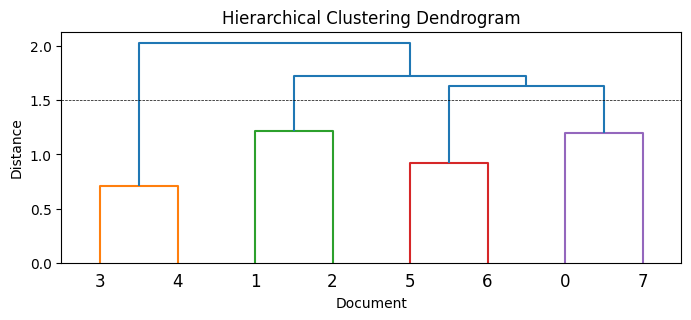

In [35]:
from matplotlib.pyplot import figure
Z = linkage(similarity_matrix, 'ward')                                                                           # use ward-linkage function, apply to similarity_matrix

plt.figure(figsize=(8,3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Document')
plt.ylabel('Distance')
dendrogram(Z)                                                                           # plot a dendrogram of Z
plt.axhline(y=1.5, c='k', ls='--', lw=0.5)
plt.show()

> **What can we deduce from this visualization? How does this relate to our results from the similarity matrix?**

We can deduce the general number of different topics or genres among the documents.

> #### **D) Cluster Labeling**

> Now we have good reason to support that there are three distinct clusters, or categories of documents. Let's add our cluster labels to our original corpus dataframe. Next, we'll try to figure out some good labels for our clusters/categories of documents.

In [36]:
max_dist = 1.5

cluster_labels = fcluster(Z, max_dist, criterion = 'distance')                            # fit clusters using Z object
cluster_labels = pd.DataFrame(cluster_labels, columns=['Cluster Label'])                               # convert cluster_labels to DF
df =  pd.concat([df, cluster_labels], axis = 1)                                                                                    # append cluster labels to corpus DF

In [37]:
df

,Customer Support Ticket,Cluster Label
0,I am unable to log in to my account. Please help!,4
1,My order has not arrived yet. When can I expect it?,2
2,"I was supposed to get my order in yesterday, but did not. What is the updated arrival date?",2
3,"I got my product but it does not fit, I would like to return it.",1
4,The product I received is damaged. I would like to return it and get a replacement.,1
5,"I want to get rid of my subscription, help me cancel it please.",3
6,I need to cancel my subscription. How can I do that?,3
7,I have forgotten my account password. How can I reset it?,4


## **3) Topic Modeling**

The last thing we need to do is replace our mystery topic labels with some logical labels. We know we have three distinct clusters of documents, so let's so which words fall into which cluster so that we can come up with appropriate cluster labels.

Topic modeling can be performed using a number of different unsupervised algorithms; we will using Latent Dirichlet Allocation (LDA) -- which we will learn more in-depth later in the semester.

In [39]:
lda = LatentDirichletAllocation(n_components = 4, max_iter=10000, random_state=0)                     # set parameters of LDA
dt_matrix = lda.fit_transform(cv_matrix)                                                                      # fit LDA to count vectorizer matrix
features = pd.DataFrame(dt_matrix, columns = ['topic_1', 'topic_2', 'topic_3', 'topic_4'])                                                     # show document-topic matrix as DF
features

,topic_1,topic_2,topic_3,topic_4
0,0.874272,0.041718,0.041714,0.042296
1,0.050103,0.050126,0.052004,0.847767
2,0.031281,0.031287,0.905706,0.031726
3,0.035747,0.892056,0.035751,0.036445
4,0.027829,0.030584,0.028034,0.913553
5,0.032451,0.031308,0.031559,0.904681
6,0.062583,0.062602,0.062595,0.812219
7,0.849855,0.050061,0.050057,0.050028


> #### **A) Extract the weights of words from each topic, display as list**

In [40]:
tt_matrix = lda.components_

for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key = lambda x: -x[1])
    topic = [item for item in topic if item[1] > 0.6]
    print(topic)
    print()

[('account', 2.2498312775957485), ('help', 1.252589474963816), ('please', 1.252589474963816), ('log', 1.2498330492381764), ('unable', 1.2498330492381764), ('forgotten', 1.2497913910484009), ('password', 1.2497913910484009), ('reset', 1.2497913910484009)]

[('like', 1.2548170668159049), ('product', 1.2548170668159049), ('return', 1.2548170668159049), ('would', 1.2548170668159049), ('fit', 1.2498949603319394), ('got', 1.2498949603319394)]

[('order', 1.2582302272099752), ('get', 1.2512581760377237), ('arrival', 1.2499015081261438), ('date', 1.2499015081261438), ('supposed', 1.2499015081261438), ('updated', 1.2499015081261438), ('yesterday', 1.2499015081261438)]

[('cancel', 2.249623069293728), ('subscription', 2.249623069293728), ('get', 2.248509531316622), ('damaged', 1.2497523489133666), ('received', 1.2497523489133666), ('replacement', 1.2497523489133666), ('rid', 1.2497457265980683), ('want', 1.2497457265980683), ('arrived', 1.2495428115084484), ('expect', 1.2495428115084484), ('yet'

> **Based on the words in these topics, how might be relabel our corpus categories?**

Topic 1: account help
Topic 2: returns
Topic 3: orders/arrivals
Topic 4: cancel subscription

> #### **B) Apply category labels to dataframe**

In [41]:
cluster_to_topics = {1: "returns",
                     2: "orders/arrivals",
                     3: "cancel subscription",
                     4: "account help"}

df['Cluster Label'].replace(cluster_to_topics, inplace = True)

In [42]:
df

,Customer Support Ticket,Cluster Label
0,I am unable to log in to my account. Please help!,account help
1,My order has not arrived yet. When can I expect it?,orders/arrivals
2,"I was supposed to get my order in yesterday, but did not. What is the updated arrival date?",orders/arrivals
3,"I got my product but it does not fit, I would like to return it.",returns
4,The product I received is damaged. I would like to return it and get a replacement.,returns
5,"I want to get rid of my subscription, help me cancel it please.",cancel subscription
6,I need to cancel my subscription. How can I do that?,cancel subscription
7,I have forgotten my account password. How can I reset it?,account help


> #### **C) We've put in a good amount of effort into creating these category labels, what are some things we could do with this information? Why is it useful?**

The first thought is directing these customers to the appropriate departments to help them with there problems. This would be the first step in automating a large chunk of the customer support services for a company. The better classified the data is, the better customers can be assisted quickly.  